In [1]:
# numpy and scipy
import numpy as np
import scipy.linalg as spl
import scipy.signal as spsg
import scipy.io as sio
import scipy.stats as stats

# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd

#statistical tests
import scipy.stats as stats

#importing ENIGMA
from enigmatoolbox.datasets import load_sc_as_one
from nilearn import plotting

In [2]:
data_dir = './' # data repo
res_dir = './' # results
graph_format = 'png' # graph formatting

conds = ['CTR', 'SCZ'] #conditions
 # number of conditions

# 68 is the number of brain regions
N = 68 # size of network for DK-68 

In [3]:
#NB: ./ = prendi il path
ts_ctr = sio.loadmat('./ts_ctr.mat')['ts_ctr'] 
ts_ctr=ts_ctr[0:68,:,20:68]
ts_scz = sio.loadmat('./ts_scz.mat')['ts_scz']
ts_scz=ts_scz[0:68]
ts_all = np.stack((ts_ctr, ts_scz), axis=-1)

ts_all.shape
#68 = brain regions
#48 = patients
#152 = time (?)
#2 = ctr, scz = conditions

(68, 152, 48, 2)

In [4]:

sc_sctx, sc_sctx_labels = load_sc_as_one()

SC = sc_sctx[0:68,0:68]

In [5]:
# create topological mask for AAL90
#SC = sio.loadmat('/Users/rodrigo/Desktop/Postdoc-Codes/ENIGMA-master/sc_ctx.mat')['sc_ctx'] 
SC=SC/np.max(SC)
lim_SC = 0.0 # limit DTI value to determine SC (only connections with larger values are tuned)

# anatomy-derived mask for existing connections for EC
mask_ECS = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_ECS[SC>lim_SC] = True
for i in range(N):
    mask_ECS[i,i] = True # no self connection
    mask_ECS[i,N-1-i] = False # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_ECS.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)
mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0


np.save(res_dir+'mask_ECS.npy',mask_ECS)
np.save(res_dir+'mask_Sigma.npy',mask_Sigma)

network size: 68
EC density: 0.31957857769973663


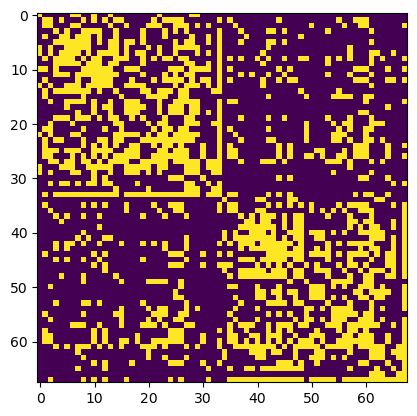

In [6]:
plt.imshow(mask_ECS)

In [7]:
# data and model parameters
subjects = np.arange(1, 48)
n_sub = len(subjects)
N = 68

mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0
conds = ['CTR', 'SCZ']
n_cond = len(conds) # number of conditions

min_val_EC = 0. # maximal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

# arrays to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC)
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model 
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)

#0.008-0.09 Hz
#0.008 to 0.08 Hz

n_order = 3
TR = 2 # in seconds
Nyquist_freq = 0.5 / TR # Nyquist frequency
low_f = 0.001 / Nyquist_freq # lower cutoff for bandpass filter
high_f = 0.01 / Nyquist_freq # upper cutoff for bandpass filter
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')

# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # Get time series
        ts3 = ts_all[0:68, :, i_sub, i_cond]
        filt_ts = spsg.filtfilt(b, a, ts3, axis=1)
        ts = stats.zscore(ts3, axis=1)
        
        # Store empirical BOLD variance
        var_BOLD[i_sub, i_cond, :] = ts.var(axis=1)
        
        # Use precomputed mask_ECS for fitting
        mask_EC = mask_ECS

        # Invert model
        mou_est = MOUv2()
        mou_est.fit(
            ts.T, 
            mask_C=mask_EC, 
            mask_Sigma=mask_Sigma, 
            algo_version='true', 
            min_iter=100, 
            epsilon_C=0.005, 
            epsilon_Sigma=0.005
        )

        # Store results
        J_mod[i_sub, i_cond, :, :] = mou_est.J
        Sigma_mod[i_sub, i_cond, :, :] = mou_est.Sigma
        FC0_mod[i_sub, i_cond, :, :] = spl.solve_lyapunov(J_mod[i_sub, i_cond, :, :].T, -Sigma_mod[i_sub, i_cond, :, :])
        err_mod[i_sub, i_cond] = mou_est.d_fit['distance']
        fit_mod[i_sub, i_cond] = mou_est.d_fit['correlation']

        print('sub', i_sub, '; cond', i_cond, ':', mou_est.d_fit)


sub 0 ; cond 0 : {'n_tau': 2, 'iterations': 102, 'distance': np.float64(0.8653155386727823), 'correlation': np.float64(0.5152413873398761), 'distance history': array([0.91124857, 0.9104506 , 0.90966077, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.38559493, 0.38807989, 0.39053407, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.8211478758796318), 'distFC1': np.float64(0.9103190661273138)}
sub 0 ; cond 1 : {'n_tau': 2, 'iterations': 102, 'distance': np.float64(0.8884973281411495), 'correlation': np.float64(0.5115351325616517), 'distance history': array([0.91644941, 0.91482161, 0.9133242 , ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.37261965, 0.38568519, 0.39770089, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(22.69412037238209), 'distFC1': np.float64(349.87509003683033)}
sub 1 ; cond 0 : {'n_tau': 2, 'iterations': 104, 'distance': np.float64(0.8817729806044945)

/tmp/ipykernel_66608/2573013235.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_66608/2573013235.py:16: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_66608/2573013235.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_66608/2573013235.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)


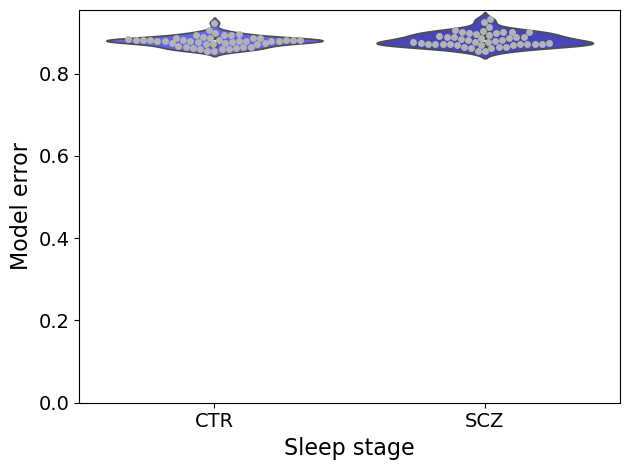

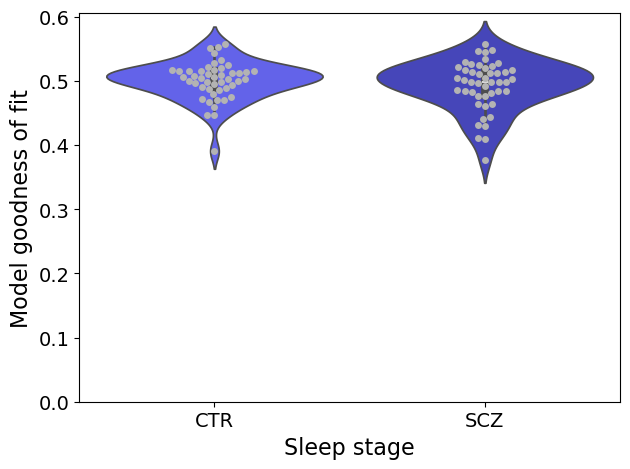

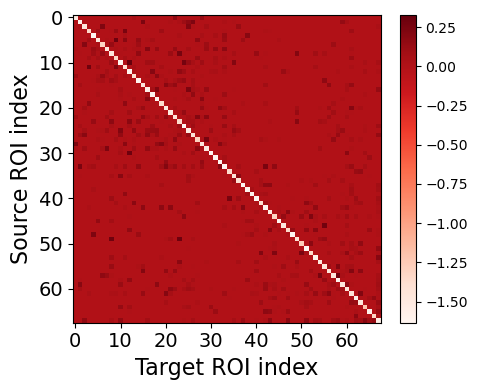

In [8]:
mask_diag = np.eye(N, dtype=bool) # mask for diagonal elements
n_cond=2

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]] # colors

# model error #err_mod

err_mod_tmp = dict()
err_mod_tmp['sum EC'] = err_mod.flatten()
err_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
err_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

err_mod_df = pd.DataFrame(err_mod_tmp)

plt.figure()
sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=err_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Sleep stage',fontsize=16)
plt.ylabel('Model error',fontsize=16)

plt.tight_layout()
plt.savefig(res_dir+'model_fit_error.eps', format='eps')


# Pearson corr #fit_mod

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)

plt.figure()
sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=fit_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Sleep stage',fontsize=16)
plt.ylabel('Model goodness of fit',fontsize=16)

plt.tight_layout()
plt.savefig(res_dir+'model_goodness_fit.eps', format='eps')


# Example EC

plt.figure(figsize=(5,4))
#plt.imshow(np.maximum(J_mod[18,1,:,:],0), cmap='Reds')
plt.imshow(J_mod[18,1,:,:], cmap='Reds')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'example_EC.eps', format='eps')